<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/NN_bwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [2]:
%pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 6.7 MB/s eta 0:00:00


In [3]:
import torchmetrics
import torchvision

Loading and preprocessing the data

In [4]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/1.0.0.incompleteKMP812/penguins-train.tfrecord*...:   0…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.


In [5]:
# By default, the Dataset object is an iterator over the elements.
# The instructions below extract the underlying tensors.
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [7]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [8]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

Define MultiLayer Neural Network

In [9]:
from torch import nn
from torch.nn import functional as F

In [10]:
class MNN(nn.Module):
  def __init__(self, input_size, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b):
    super().__init__()

    self.w1 = nn.Parameter(fc1w)
    self.b1 = nn.Parameter(fc1b)
    
    self.w2 = nn.Parameter(fc2w)
    self.b2 = nn.Parameter(fc2b)

    self.w3 = nn.Parameter(fc3w)
    self.b3 = nn.Parameter(fc3b)

  def forward(self, x):
    x = F.relu(x@self.w1 + self.b1)
    x = F.relu(x@self.w2 + self.b2)
    x = x@self.w3 + self.b3
    x = x.reshape(1, -1)

    return torch.softmax(x, 1)

In [11]:
# We check if CUDA is available. If you do not see it,
# activate a GPU from Runtime >> Change runtime type and 
# restart the notebook.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Initialize the parameters

In [12]:
# We initialize the parameters randomly with values in [-1, 1] and the model with an input size
fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1)
fc1b = torch.FloatTensor(64).uniform_(-1, 1)
fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1)
fc2b = torch.FloatTensor(8).uniform_(-1, 1)
fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1)
fc3b = torch.FloatTensor(3).uniform_(-1, 1)
mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b).to(device)

In [13]:
# Note: we also need to move data when asking for a prediction
print(mnn(Xtrain[0].to(device)))

tensor([[5.4280e-02, 9.4558e-01, 1.3852e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


Calculate predictions

In [14]:
def pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, x):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return ypred

Define accuracy

In [15]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [16]:
# Average accuracy at initialization is 10% (random guessing).
accuracy(ytrain.to(device), mnn(Xtrain.to(device)))

tensor(0., device='cuda:0')

Define Cross-Entropy

In [17]:
def cross_entropy(ytrue, ypred):
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [18]:
ypred = pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, Xtrain)
print(cross_entropy(ytrain, ypred))

tensor(4.9033)


Train and evaluate the network

In [28]:
import time 

In [37]:
def train_bwd_gradient(x, y):
  losses = []
  accuracies = []
  errors = []

  #Parameters
  fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1).requires_grad_(True)
  fc1b = torch.FloatTensor(64).uniform_(-1, 1).requires_grad_(True)
  fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1).requires_grad_(True)
  fc2b = torch.FloatTensor(8).uniform_(-1, 1).requires_grad_(True)
  fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1).requires_grad_(True)
  fc3b = torch.FloatTensor(3).uniform_(-1, 1).requires_grad_(True)

  ypred = pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, x)
  loss = cross_entropy(y, ypred)

  #mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)

  t = 0
  t0 = time.time()
  while loss>0.2:

    #Compute the gradients
    loss.backward()

    with torch.no_grad():

      #Apply gradients
      fc1w -= 0.05*fc1w.grad
      fc1b -= 0.05*fc1b.grad
      fc2w -= 0.05*fc2w.grad
      fc2b -= 0.05*fc2b.grad
      fc3w -= 0.05*fc3w.grad
      fc3b -= 0.05*fc3b.grad

      # Gradients are accumulated: we need to zero them out before the next iteration
      fc1w.grad.zero_()
      fc1b.grad.zero_()
      fc2w.grad.zero_()
      fc2b.grad.zero_()
      fc3w.grad.zero_()
      fc3b.grad.zero_()

      losses.append(loss.detach().item())
      accuracies.append(accuracy(ytrain, ypred).item())
      mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
      ypred=torch.randn(Xtest.size(0),3)
      error=0
      for i in range (Xtest.size(0)):
        ypred[i]=mnn(Xtest[i])
        if (mnn(Xtest[i]).argmax(1)- ytest[i])!=0:
          error = error+ 1
      errors.append(error)

    t1=time.time()
    t+=t1-t0
    t0=t1
    print('Time', t, 'loss', loss)

    #Compute the predictions
    ypred = pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, x)

    #Compute the loss
    loss = cross_entropy(y, ypred)

  return fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies, errors

In [38]:
fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies, errors = train_bwd_gradient(Xtrain, ytrain)

Time 0.04843568801879883 loss tensor(1.6648, grad_fn=<NegBackward0>)
Time 0.1211857795715332 loss tensor(1.2917, grad_fn=<NegBackward0>)
Time 0.19450664520263672 loss tensor(1.0685, grad_fn=<NegBackward0>)
Time 0.2684764862060547 loss tensor(0.9370, grad_fn=<NegBackward0>)
Time 0.3395988941192627 loss tensor(0.8584, grad_fn=<NegBackward0>)
Time 0.41122865676879883 loss tensor(0.8098, grad_fn=<NegBackward0>)
Time 0.4840400218963623 loss tensor(0.7761, grad_fn=<NegBackward0>)
Time 0.6636950969696045 loss tensor(0.7478, grad_fn=<NegBackward0>)
Time 0.9939289093017578 loss tensor(0.7218, grad_fn=<NegBackward0>)
Time 1.2278759479522705 loss tensor(0.6974, grad_fn=<NegBackward0>)
Time 1.3693809509277344 loss tensor(0.6740, grad_fn=<NegBackward0>)
Time 1.448606252670288 loss tensor(0.6512, grad_fn=<NegBackward0>)
Time 1.5205693244934082 loss tensor(0.6291, grad_fn=<NegBackward0>)
Time 1.59637451171875 loss tensor(0.6083, grad_fn=<NegBackward0>)
Time 1.6772634983062744 loss tensor(0.5885, grad

In [39]:
import matplotlib.pyplot as plt

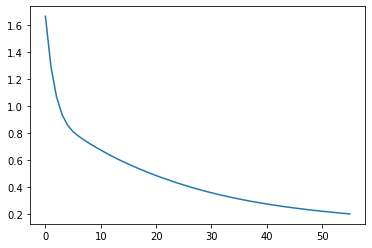

In [40]:
plt.plot(losses)

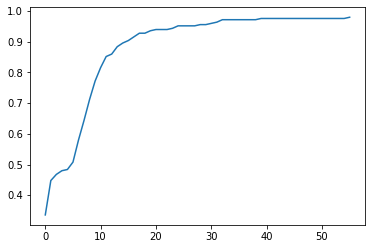

In [41]:
plt.plot(accuracies)

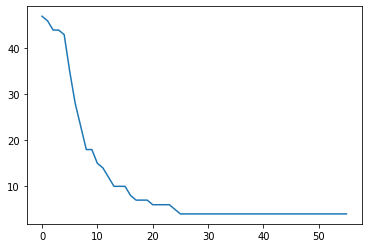

In [42]:
plt.plot(errors)